### Duel output UNet on pennate diatoms - first attempt
### Rayna Hamilton
### March 21, 2025

We will train a UNet neural network to detect the locations of pennate diatom cells in strained microscopy images.  This cell segmentation approach was first introduced by [Ronnenberger et al., 2015](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28).  My initial testing with this code suggested that nearby cells are often merged together by this segmentation approach, so I am taking from inspiration from the [Duel-Output Unet approach](https://github.com/ToyahJade/DO-U-Net), which addressed the issue of close-together objects by training a network to detect both objects and outlines, then subtracting the outline prediction from the object body prediction.  For this application, I am just going to train two networks, one on cell body annotations, and one on cell outlines.  The ultimate goal of this project is to predict the parasite infection status of each individual cell, but to do this we first need to determine the locations of boundaries of individual cells in the images.

In [1]:
# U-NET CNN Approach to Automated Image Analysis
    # base code from: https://www.kaggle.com/code/vbookshelf/simple-cell-segmentation-with-keras-and-u-net
#-------------------------------------------------------------------------------------------------------------

# Read in libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
# %matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
# warnings.filterwarnings('ignore')

IMG_TILE_SIZE=400
IMG_CHANNELS = 3 # RGB


In [2]:
# Read in data
mother_directory = "../../data/train_images/" 
    # home of analyzed output images & csvs
child_directory_image = "ML_output/images/"
child_directory_csv = "ML_output/csvs/"


if not os.path.isdir(child_directory_csv):
    os.mkdir(child_directory_csv)
if not os.path.isdir(child_directory_image):
    os.mkdir(child_directory_image)

#-------------------------------------------------------------------------------------------------------------

# get a list of files in each folder
mask_dir = "../../data/binary_masks/train/"
outline_mask_dir = "../../data/outlines/train/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]
outline_mask_list = os.listdir(outline_mask_dir)
outline_mask_list=[val for val in outline_mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

df_images

image_id
0     AS_A_I_15_4-20240720-C28.jpg
1     AS_A_I_22_4-20240718-C15.jpg
2     AS_A_I_22_5-20240718-C13.jpg
3     AS_B_I_15_4-20240724-C29.jpg
4     AS_B_I_22_5-20240720-C36.jpg
5     AS_B_I_22_6-20240717-C10.jpg
6     AS_B_U_15_1-20240726-C30.jpg
7     AS_C_I_15_2-20240726-C21.jpg
8     AS_C_I_15_3-20240724-C32.jpg
9     AS_C_U_15_3-20240717-C21.jpg
10   AS_Starter_1-20240711-C44.jpg
11   AS_STARTER_2-20240716-C33.jpg
12   AS_Starter_3-20240711-C11.jpg
13   AS_STARTER_5-20240716-C20.jpg
14   THN_A_I_15_1-20240717-C18.jpg
15   THN_A_I_15_1-20240724-C15.jpg
16   THN_A_I_22_1-20240717-C45.jpg
17   THN_A_I_22_3-20240724-C24.jpg
18   THN_B_I_15_5-20240726-C26.jpg
19   THN_C_I_15_3-20240724-C34.jpg
20   THN_C_I_15_4-20240720-C45.jpg
21   THN_C_I_22_2-20240720-C12.jpg
22  THN_STARTER_1-20240716-C27.jpg
23  THN_Starter_2-20240711-C26.jpg
24  THN_STARTER_4-20240716-C30.jpg
25  THN_Starter_5-20240711-C24.jpg

The training data labels are termed binary masks, meaning that all pixels in the image are either 1 (cell) or 0 (non-cell).  Currently, I have more cell body annotations than cell outline annotations, but hopefully we will have more annotations of both for subsequent runs.

In [3]:
# ================================================
# Add a column indicating if an image has a mask for outline and cell contents
# ================================================

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in [val.replace("_masks","") for val in somelist]:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
somelist=mask_list
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)
somelist=outline_mask_list
df_images['has_outline_mask'] = df_images['image_id'].apply(check_for_mask)
df_images

image_id has_mask has_outline_mask
0     AS_A_I_15_4-20240720-C28.jpg      yes               no
1     AS_A_I_22_4-20240718-C15.jpg      yes               no
2     AS_A_I_22_5-20240718-C13.jpg      yes               no
3     AS_B_I_15_4-20240724-C29.jpg      yes               no
4     AS_B_I_22_5-20240720-C36.jpg      yes               no
5     AS_B_I_22_6-20240717-C10.jpg      yes               no
6     AS_B_U_15_1-20240726-C30.jpg      yes               no
7     AS_C_I_15_2-20240726-C21.jpg      yes               no
8     AS_C_I_15_3-20240724-C32.jpg      yes               no
9     AS_C_U_15_3-20240717-C21.jpg      yes               no
10   AS_Starter_1-20240711-C44.jpg      yes               no
11   AS_STARTER_2-20240716-C33.jpg      yes               no
12   AS_Starter_3-20240711-C11.jpg      yes               no
13   AS_STARTER_5-20240716-C20.jpg      yes               no
14   THN_A_I_15_1-20240717-C18.jpg      yes               no
15   THN_A_I_15_1-20240724-C15.jpg      yes               no
16   THN_A_I_22_1-20240717-C45.jpg      yes               no
17   THN_A_I_22_3-20240724-C24.jpg      yes               no
18   THN_B_I_15_5-20240726-C26.jpg       no               no
19   THN_C_I_15_3-20240724-C34.jpg      yes               no
20   THN_C_I_15_4-20240720-C45.jpg      yes               no
21   THN_C_I_22_2-20240720-C12.jpg      yes               no
22  THN_STARTER_1-20240716-C27.jpg      yes               no
23  THN_Starter_2-20240711-C26.jpg      yes               no
24  THN_STARTER_4-20240716-C30.jpg      yes               no
25  THN_Starter_5-20240711-C24.jpg       no               no

In [4]:

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

C:\Users\Rayna\AppData\Local\Temp\ipykernel_124728\3158210854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = [val for val in df_masks['image_id']]


(24, 4)

In [5]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
# Create empty arrays

X = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
y = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    # read the image using skimage
    image = imread(path_image)
    X[i] = image
    
X.shape

(24, 1040, 1388, 3)

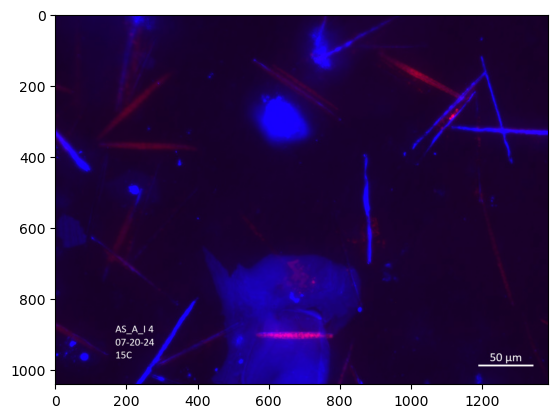

In [6]:
plt.imshow(X[0])

In the above sample image, blue lines are late-stage infected cells, and red lines are healthy cells.

In [7]:
y_cell,y_outline=[],[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    # read the image using skimage
    mask = imread(path_mask)[:,:,0]
    y_cell.append(mask)
    if mask_id in outline_mask_list:
        path_mask =outline_mask_dir + mask_id
        mask = imread(path_mask)
        y_outline.append(mask)
y_cell,y_outline=np.array(y_cell),np.array(y_outline)
y_cell.shape

(24, 1040, 1388)

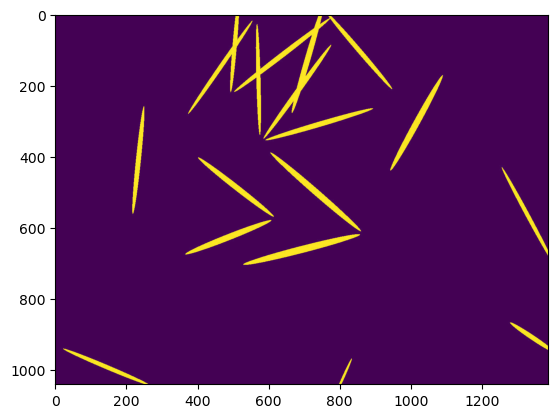

In [8]:
plt.imshow(y_cell[14])

Above are examples of the cell binary mask and outline annotation that will be used for training the networks.  Below I am splitting up the images into 400-by-400 pixel chunks, with some overlap between windows to augment our training data.  This is necessary as the network architecture requires square images and is quite picky about dimensions, but I have found that resizing the images results in an undesirable amount of distortion, particularly for the outlines.

In [9]:
X.shape

(24, 1040, 1388, 3)

In [10]:
#figure out how to join results for slices of images into a single image.   allow for overlap in edge slices

In [11]:
tiled_x_cell=[]

max_x,max_y=1040,1388
for i in range(len(X)):
    tiled_x_cell.append([])
    for y_pos in [0,400,800,1200]:
        for x_pos in [0,400,800]:
            image_slice=np.zeros((400,400,3), dtype=np.uint8)
            x_range=min(400,max_x-x_pos)
            y_range=min(400,max_y-y_pos)
            if x_range==400:
                if y_range==400:
                    image_slice=X[i,x_pos:x_pos+400,y_pos:y_pos+400]
                else:
                    image_slice=X[i,x_pos:x_pos+400,max_y-400:max_y]
            else:
                if y_range==400:
                    image_slice=X[i,max_x-400:max_x,y_pos:y_pos+400]
                else:
                    image_slice=X[i,max_x-400:max_x,max_y-400:max_y]
            tiled_x_cell[-1].append(image_slice)

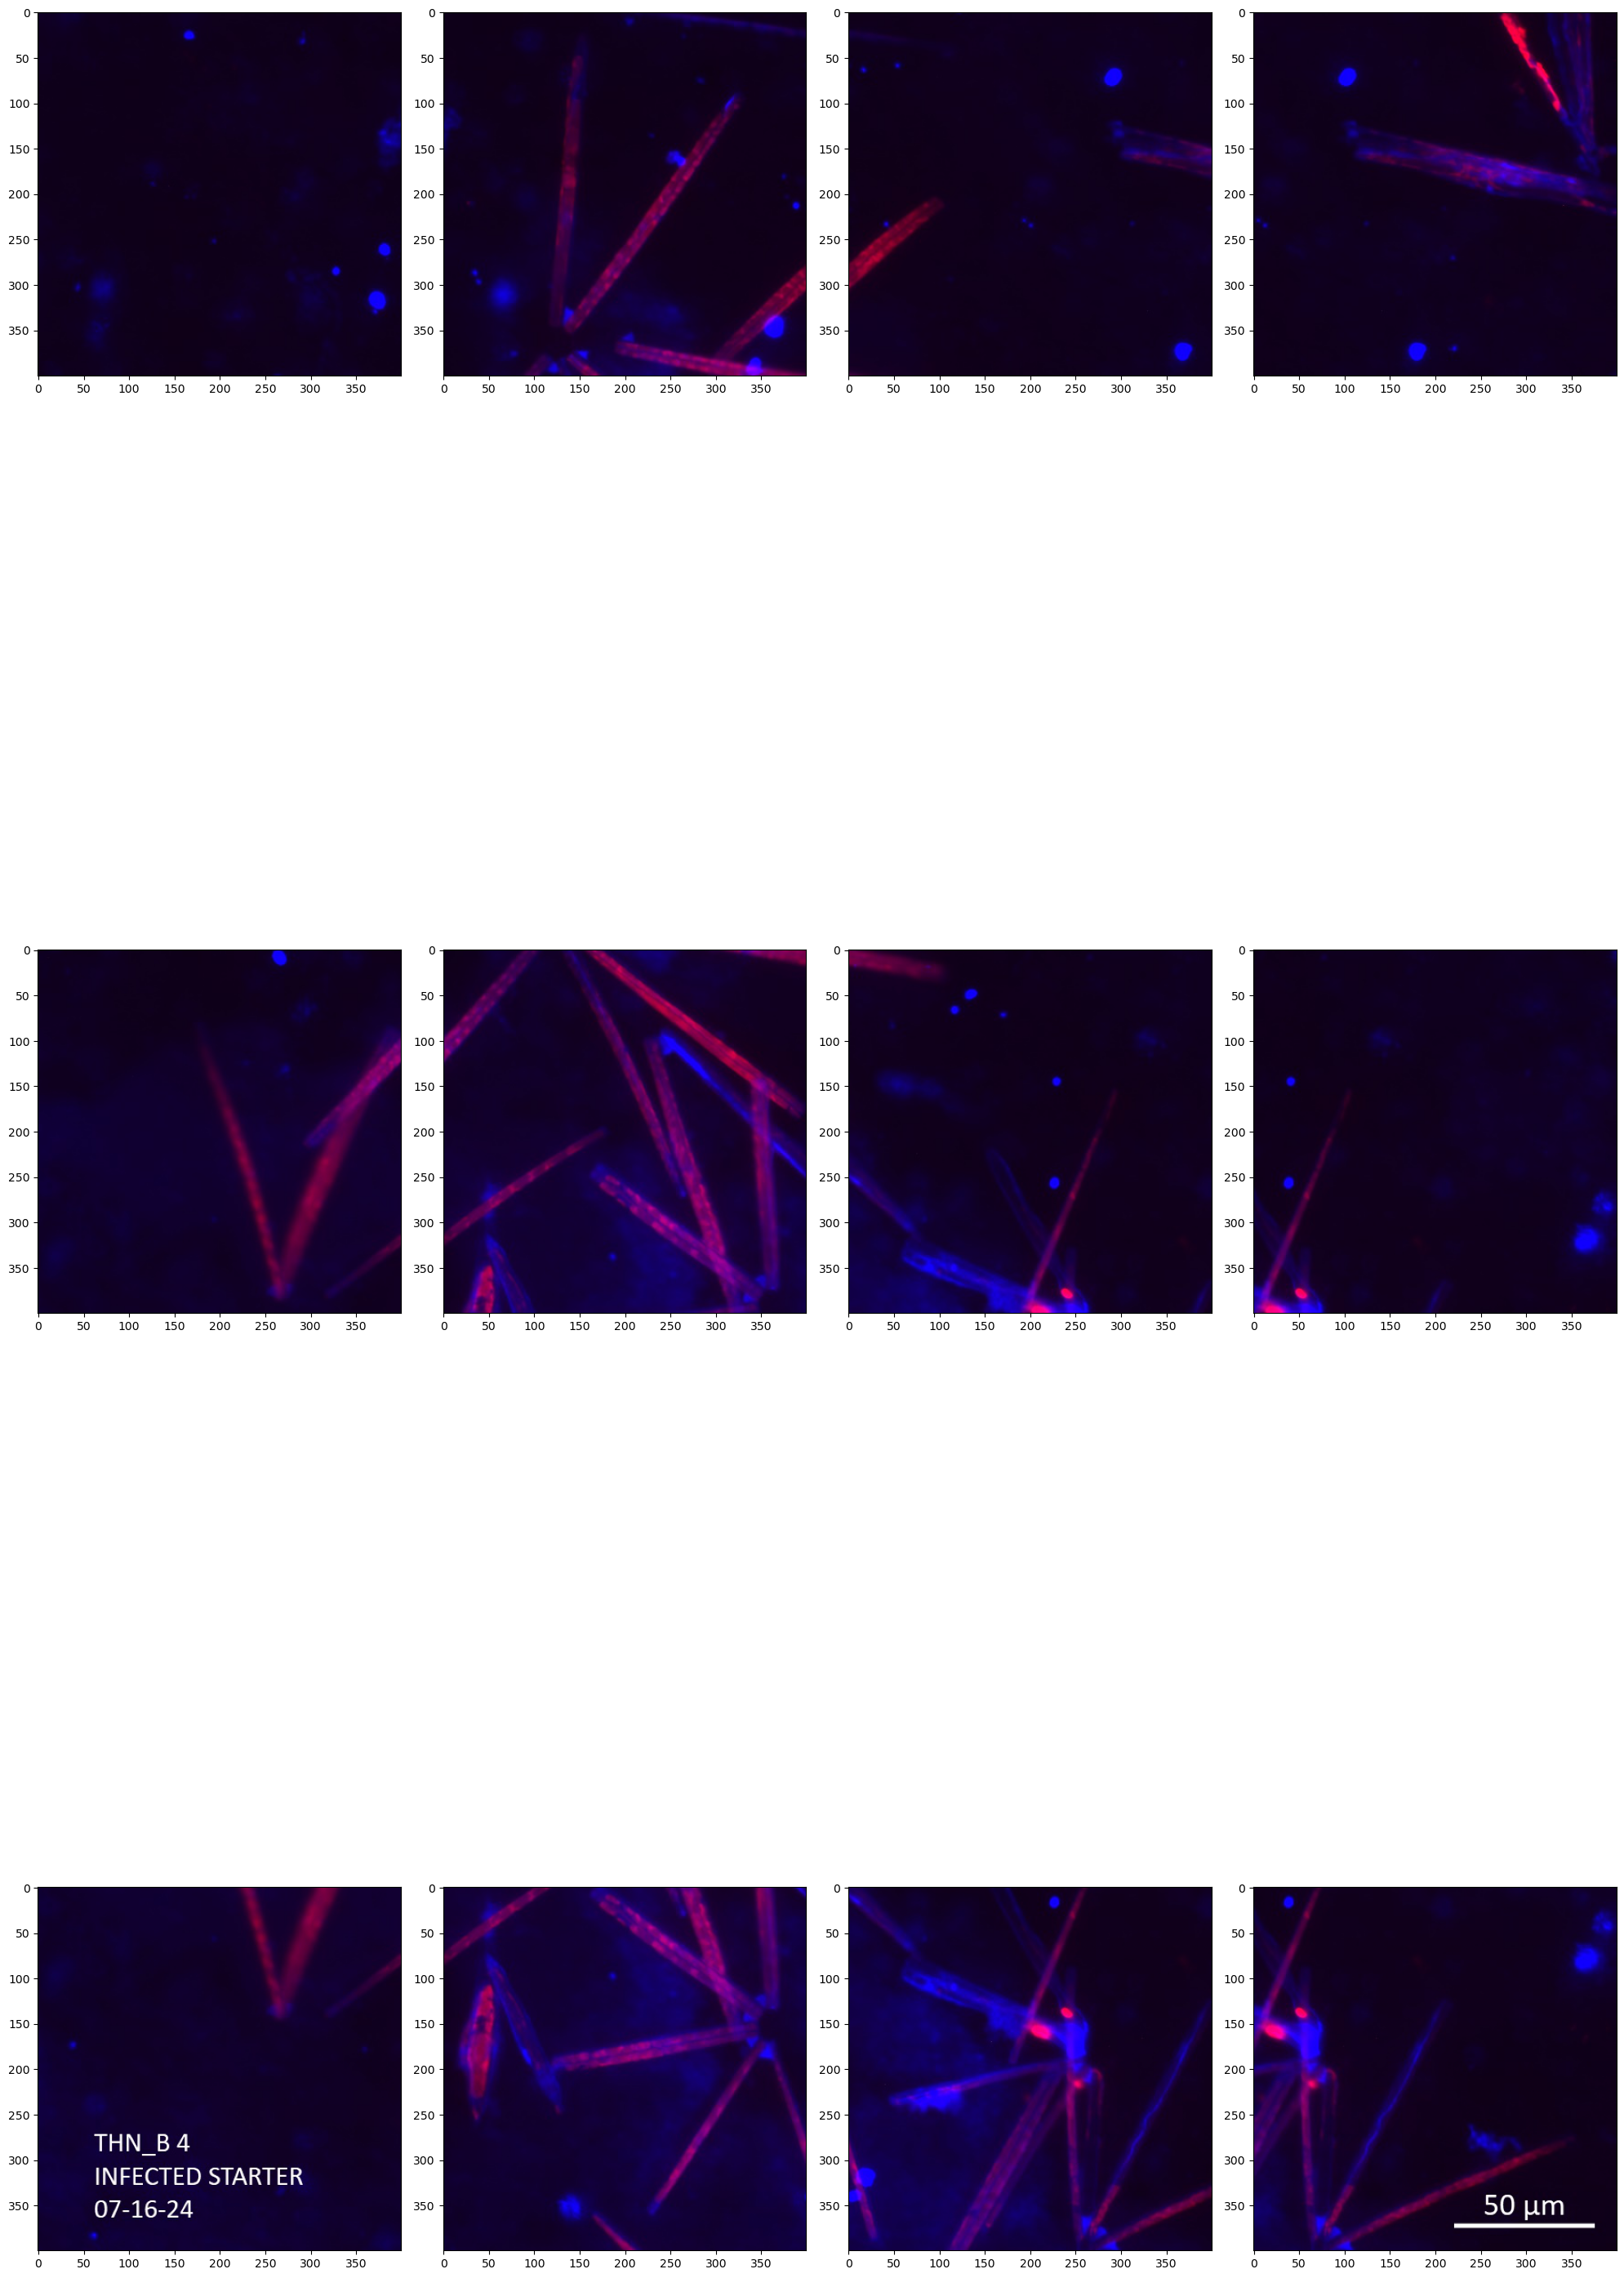

In [12]:
#make sure these are ordered correctly
fig, ax = plt.subplots(3,4, figsize=(20, 40))

for i in range(0,12):
    ax[i%3,int(i/3)].imshow(tiled_x_cell[-1][i])
fig.tight_layout()

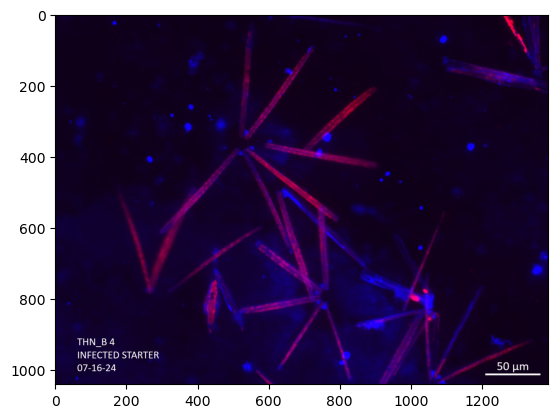

In [13]:
#for comparison, the original image
plt.imshow(X[-1])

In [14]:
#looks correct, moving on


In [15]:

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [16]:
IMG_CHANNELS=3
inputs = Input((400,400, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',loss_weights=[1,1000])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

We must normalize our y data, which currently ranges from 0 to 255, to range from 0 to 1, as otherwise we will encounter issues in loss function calculation.

In [17]:
y_cell=y_cell/255
y_cell[y_cell>0]=1

In [18]:
model.load_weights('models/cell_model.h5')


In [19]:
predictions=model.predict(np.array(tiled_x_cell[-1]))

1/1 [==============================] - 1s 650ms/step


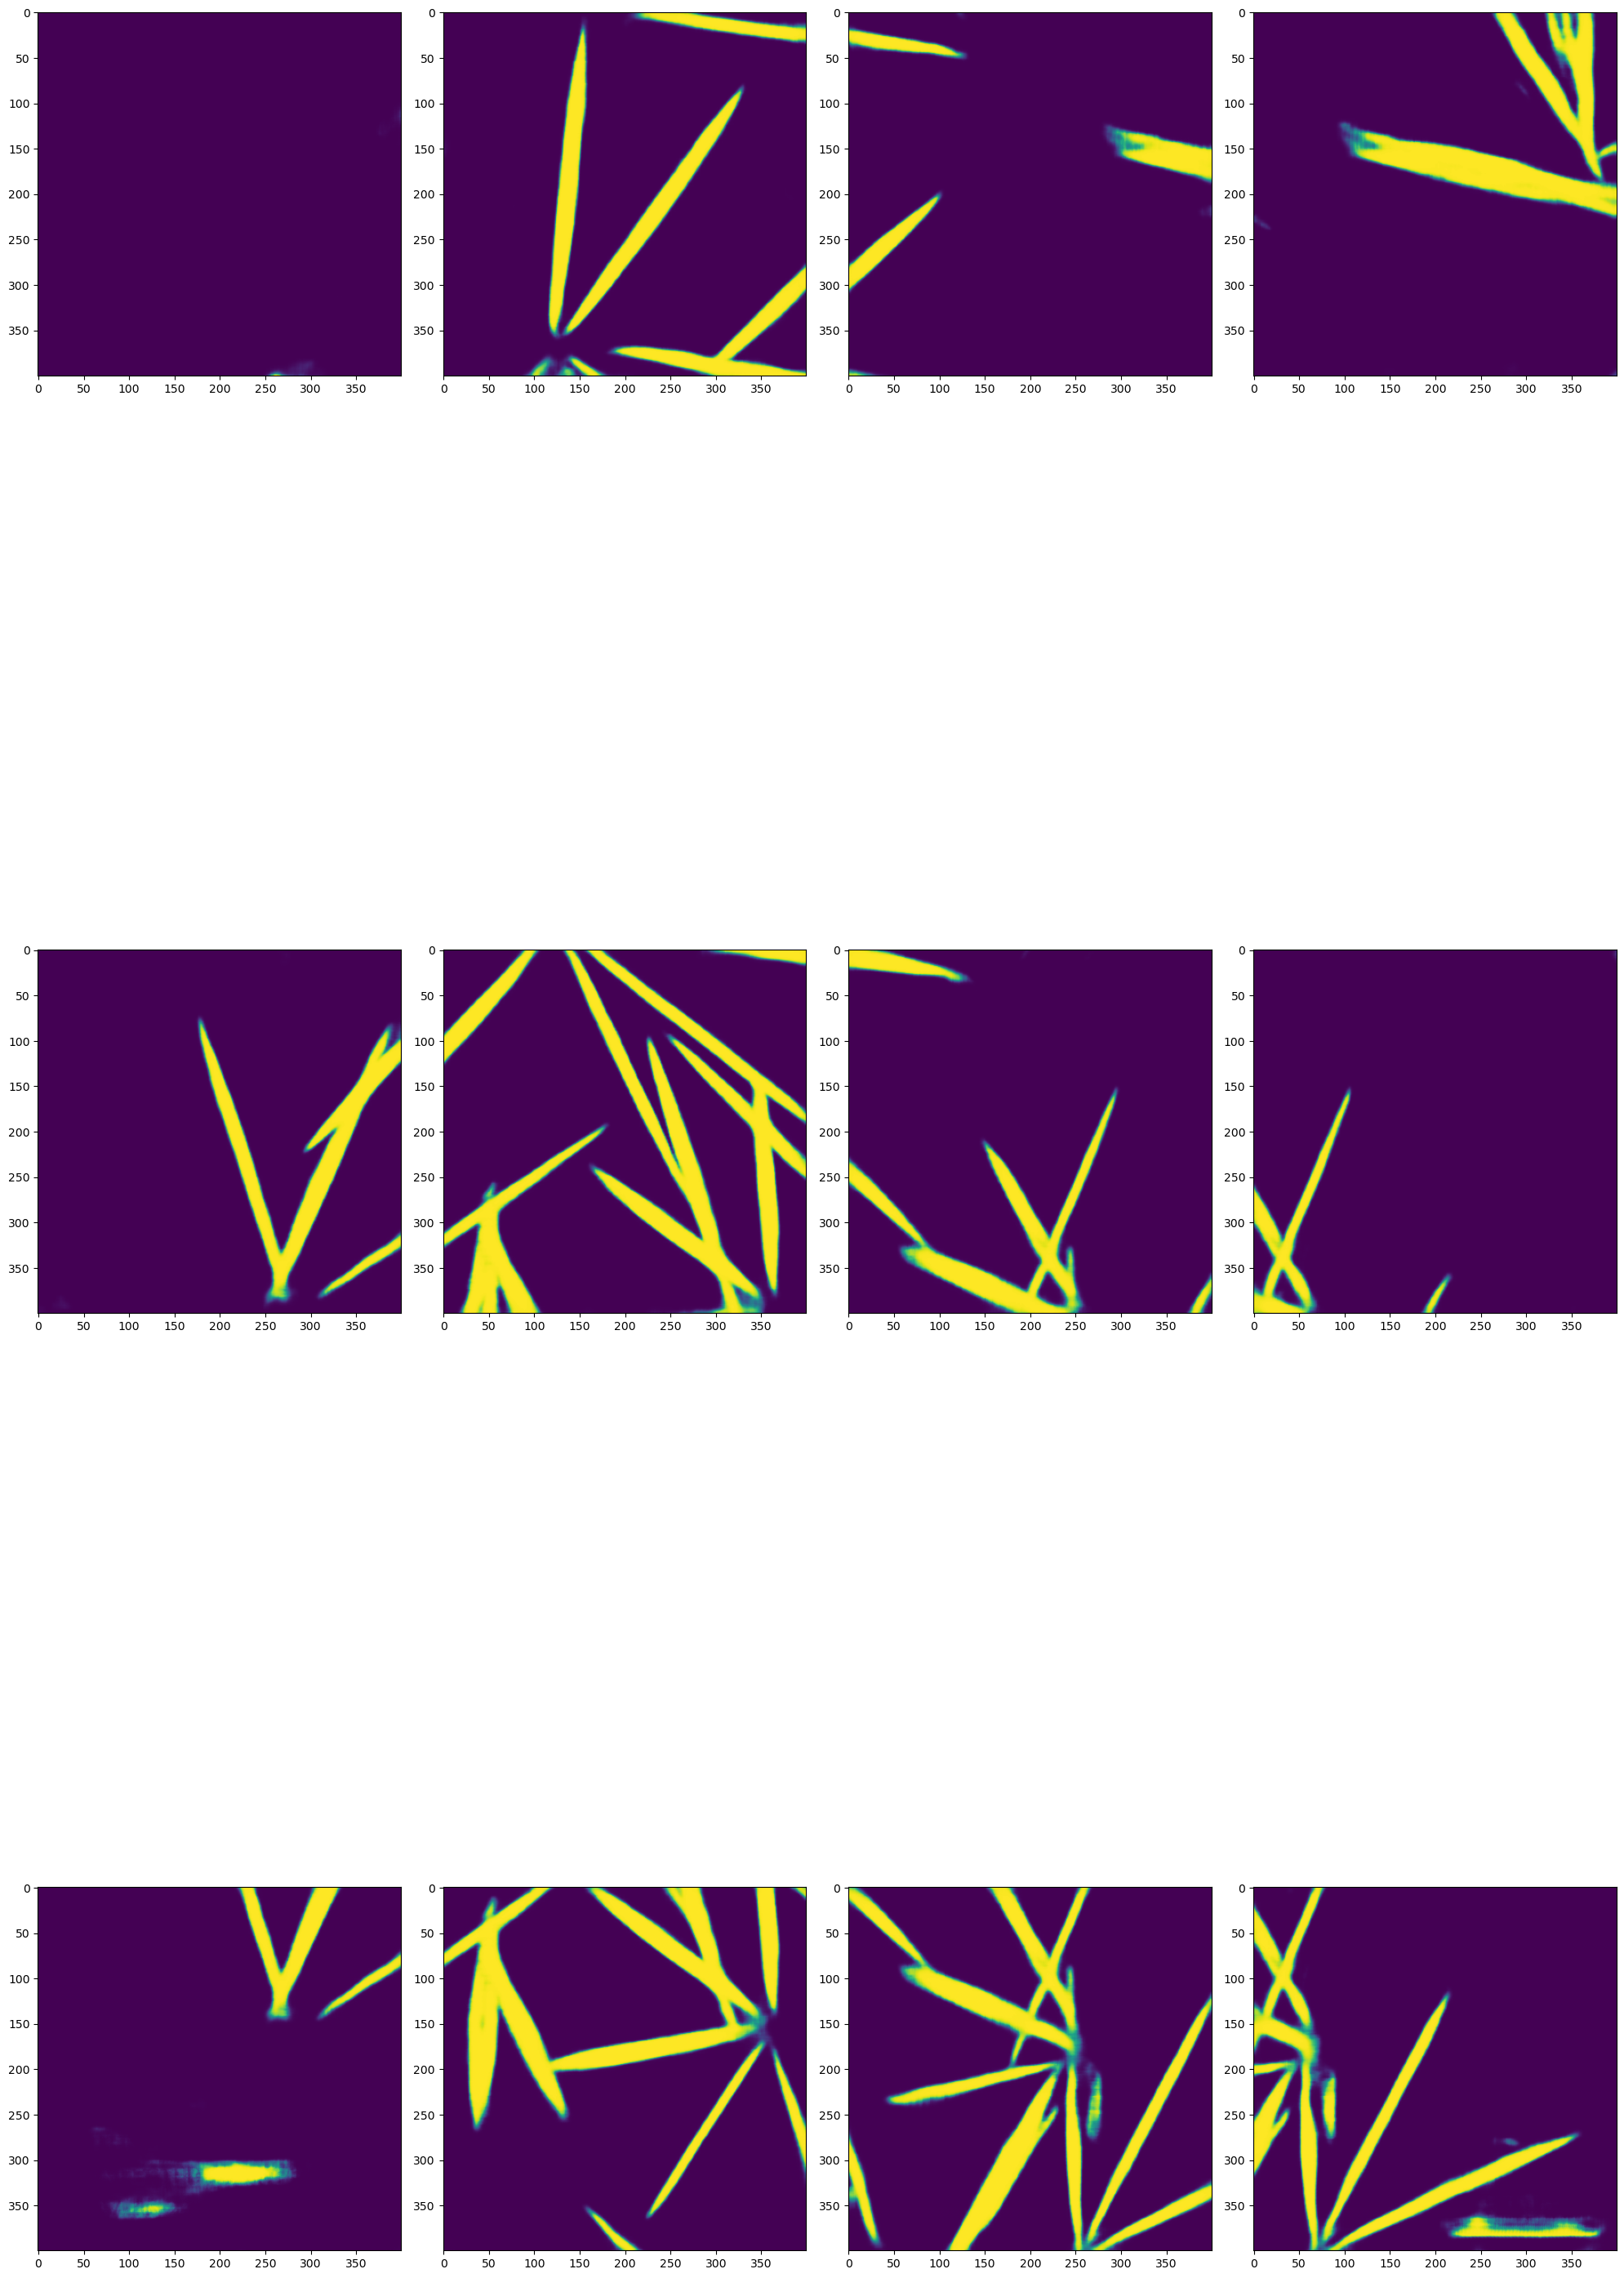

In [20]:
fig, ax = plt.subplots(3,4, figsize=(20, 40))

for i in range(0,12):
    ax[i%3,int(i/3)].imshow(predictions[i])
fig.tight_layout()

In [21]:
single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)

In [22]:
#get predictions back into a single np array per image
single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)
max_x,max_y=1040,1388
single_prediction=np.zeros((1040,1388,1),dtype=np.float64)
for i in range(len(predictions)):
    if i%3*400+400<max_x and int(i/3)*400+400<max_y:
        '''for x_pos in range(0,400):
            for y_pos in range(0,400):
                single_prediction[int(i%3*400+x_pos), int(int(i/3)*400+y_pos),0]=predictions[1][x_pos,y_pos][0]'''
        single_prediction[i%3*400:i%3*400+400,int(i/3)*400:int(i/3)*400+400,:]=predictions[i]
    elif i%3*400+400<max_x and int(i/3)*400+400>max_y:
        single_prediction[i%3*400:i%3*400+400,int(i/3)*400:max_y,:]=predictions[i][:,400-(max_y-int(i/3)*400):]
    elif i%3*400+400>max_x and int(i/3)*400+400<max_y:
        single_prediction[i%3*400:max_x,int(i/3)*400:int(i/3)*400+400,:]=predictions[i][400-(max_x-i%3*400):,:]
    else:
        print(i)
        print(predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:].shape)
        single_prediction[i%3*400:max_x,int(i/3)*400:max_y,:]=predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:]


11
(240, 188, 1)


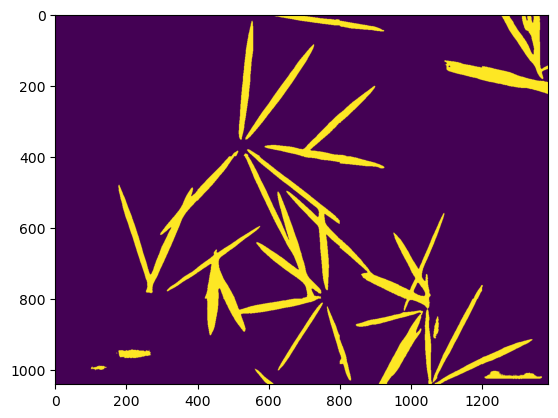

In [23]:
plt.imshow(single_prediction>0.5)

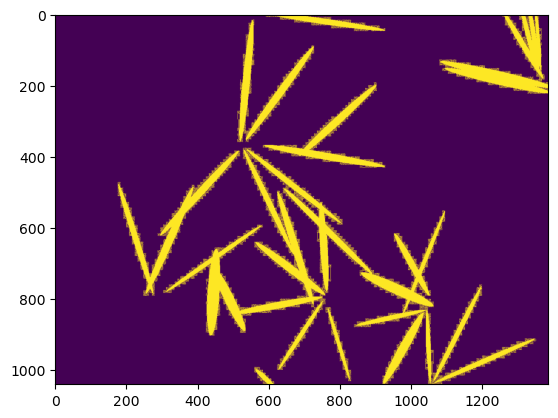

In [24]:
plt.imshow(y_cell[-1])

In [25]:

np.sum(y_cell[-1]==((single_prediction>0.5)[:,:,0]))/(1388*1040)

0.966643344047883

In [26]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

In [27]:
DICE_COE(y_cell[-1],(single_prediction>0.5)[:,:,0])

0.839

In [28]:
joined_predictions=[]
for j in range(len(X)):
    predictions=model.predict(np.array(tiled_x_cell[j]))
    single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)
    max_x,max_y=1040,1388
    single_prediction=np.zeros((1040,1388,1),dtype=np.float64)
    for i in range(len(predictions)):
        if i%3*400+400<max_x and int(i/3)*400+400<max_y:
            '''for x_pos in range(0,400):
                for y_pos in range(0,400):
                    single_prediction[int(i%3*400+x_pos), int(int(i/3)*400+y_pos),0]=predictions[1][x_pos,y_pos][0]'''
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:int(i/3)*400+400,:]=predictions[i]
        elif i%3*400+400<max_x and int(i/3)*400+400>max_y:
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:max_y,:]=predictions[i][:,400-(max_y-int(i/3)*400):]
        elif i%3*400+400>max_x and int(i/3)*400+400<max_y:
            single_prediction[i%3*400:max_x,int(i/3)*400:int(i/3)*400+400,:]=predictions[i][400-(max_x-i%3*400):,:]
        else:
            single_prediction[i%3*400:max_x,int(i/3)*400:max_y,:]=predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:]
    joined_predictions.append(single_prediction)

1/1 [==============================] - 0s 345ms/step


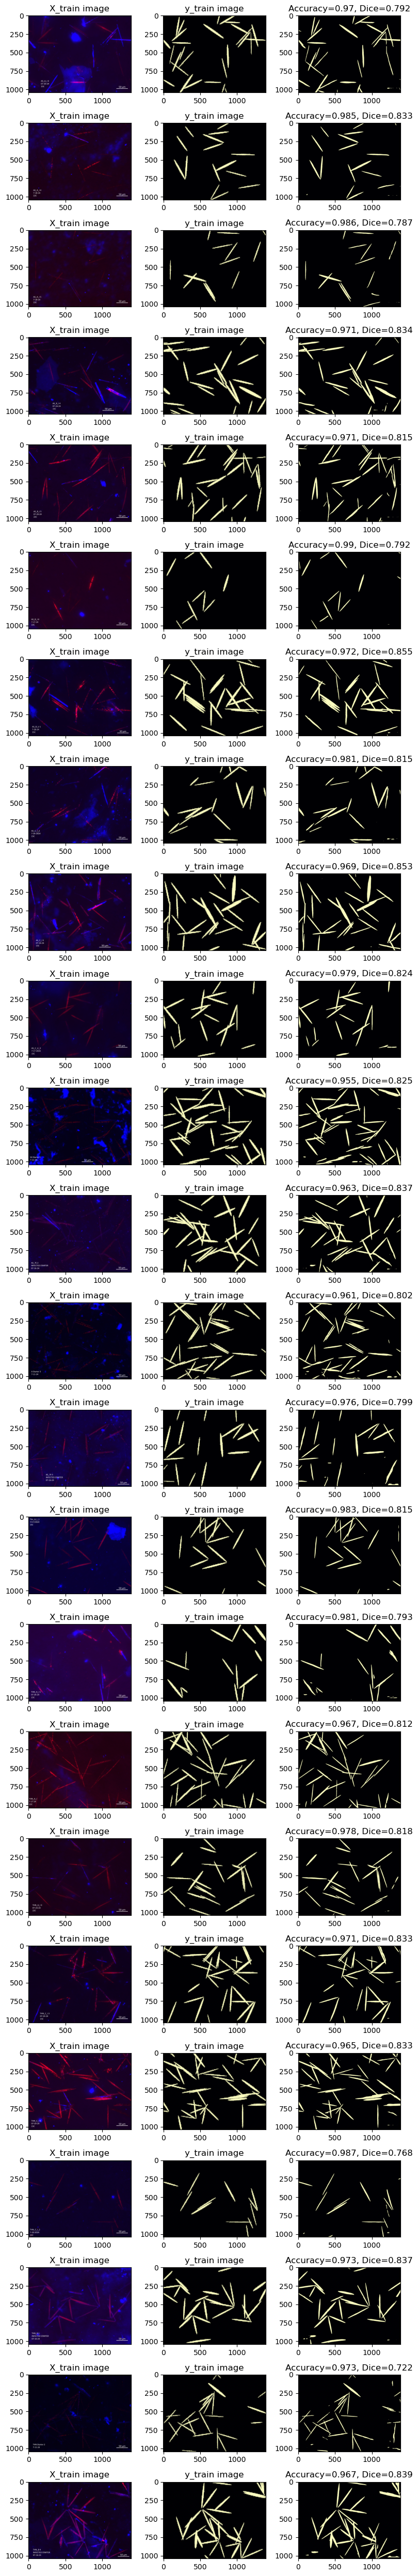

In [29]:
accuracies,dice_scores=[],[]
fig, ax = plt.subplots(24, 3, figsize=(8, 50))
for i in range(len(X)):
    accuracy=np.sum(y_cell[i]==((joined_predictions[i]>0.5)[:,:,0]))/(1388*1040)
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(y_cell[i], cmap='magma')
    ax[i,2].imshow(joined_predictions[i]>0.5, cmap='magma')
    ax[i,0].set_title("X_train image")
    ax[i,1].set_title("y_train image")
    ax[i,2].set_title("Accuracy="+str(round(accuracy,3))+", Dice="+str(DICE_COE(y_cell[i],(joined_predictions[i]>0.5)[:,:,0])))
    accuracies.append(accuracy)
    dice_scores.append(DICE_COE(y_cell[i],(joined_predictions[i]>0.5)[:,:,0]))
fig.tight_layout()

In [30]:
np.mean(accuracies)

0.9739767778301189

In [31]:
np.mean(dice_scores)

0.813875

In [32]:
# Read in data
mother_directory = "../../data/test_images/" 
    # home of analyzed output images & csvs
child_directory_image = "ML_output/images/"
child_directory_csv = "ML_output/csvs/"


if not os.path.isdir(child_directory_csv):
    os.mkdir(child_directory_csv)
if not os.path.isdir(child_directory_image):
    os.mkdir(child_directory_image)

#-------------------------------------------------------------------------------------------------------------

# get a list of files in each folder
mask_dir = "../../data/binary_masks/test/"
outline_mask_dir = "../../data/outlines/train/"

img_list = os.listdir(mother_directory)
img_list=[val for val in img_list if val.endswith(".jpg")]
mask_list = os.listdir(mask_dir)
mask_list=[val for val in mask_list if val.endswith(".jpg")]
outline_mask_list = os.listdir(outline_mask_dir)
outline_mask_list=[val for val in outline_mask_list if val.endswith(".jpg")]

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])


In [33]:
# ================================================
# Add a column indicating if an image has a mask for outline and cell contents
# ================================================

def check_for_mask(x):
    x=x.replace(".jpg",".jpg")
    if x in [val.replace("_masks","") for val in somelist]:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
somelist=mask_list
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)
somelist=outline_mask_list
df_images['has_outline_mask'] = df_images['image_id'].apply(check_for_mask)

In [34]:

df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = [val for val in df_masks['image_id']]

df_masks.shape

C:\Users\Rayna\AppData\Local\Temp\ipykernel_124728\3158210854.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masks['mask_id'] = [val for val in df_masks['image_id']]


(6, 4)

In [35]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
# Create empty arrays

X = np.zeros((len(image_id_list), 1040,1388,3), dtype=np.uint8)
y = np.zeros((len(image_id_list), 1040,1388), dtype=bool)
# X_train


for i, image_id in enumerate(image_id_list):
    path_image = mother_directory + image_id
    # read the image using skimage
    image = imread(path_image)
    X[i] = image
    
X.shape

(6, 1040, 1388, 3)

In [36]:
y_cell,y_outline=[],[]
for i, mask_id in enumerate(mask_id_list):
    
    path_mask =mask_dir + mask_id
    # read the image using skimage
    mask = imread(path_mask)[:,:,0]
    y_cell.append(mask)
    if mask_id in outline_mask_list:
        path_mask =outline_mask_dir + mask_id
        mask = imread(path_mask)
        y_outline.append(mask)
y_cell,y_outline=np.array(y_cell),np.array(y_outline)
y_cell.shape

(6, 1040, 1388)

In [37]:
tiled_x_cell=[]

max_x,max_y=1040,1388
for i in range(len(X)):
    tiled_x_cell.append([])
    for y_pos in [0,400,800,1200]:
        for x_pos in [0,400,800]:
            image_slice=np.zeros((400,400,3), dtype=np.uint8)
            x_range=min(400,max_x-x_pos)
            y_range=min(400,max_y-y_pos)
            if x_range==400:
                if y_range==400:
                    image_slice=X[i,x_pos:x_pos+400,y_pos:y_pos+400]
                else:
                    image_slice=X[i,x_pos:x_pos+400,max_y-400:max_y]
            else:
                if y_range==400:
                    image_slice=X[i,max_x-400:max_x,y_pos:y_pos+400]
                else:
                    image_slice=X[i,max_x-400:max_x,max_y-400:max_y]
            tiled_x_cell[-1].append(image_slice)

In [38]:
y_cell=y_cell/255

In [39]:
joined_predictions=[]
for j in range(len(X)):
    predictions=model.predict(np.array(tiled_x_cell[j]))
    single_prediction=np.zeros((1040,1388,1),dtype=np.uint8)
    max_x,max_y=1040,1388
    single_prediction=np.zeros((1040,1388,1),dtype=np.float64)
    for i in range(len(predictions)):
        if i%3*400+400<max_x and int(i/3)*400+400<max_y:
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:int(i/3)*400+400,:]=predictions[i]
        elif i%3*400+400<max_x and int(i/3)*400+400>max_y:
            single_prediction[i%3*400:i%3*400+400,int(i/3)*400:max_y,:]=predictions[i][:,400-(max_y-int(i/3)*400):]
        elif i%3*400+400>max_x and int(i/3)*400+400<max_y:
            single_prediction[i%3*400:max_x,int(i/3)*400:int(i/3)*400+400,:]=predictions[i][400-(max_x-i%3*400):,:]
        else:
            single_prediction[i%3*400:max_x,int(i/3)*400:max_y,:]=predictions[i][400-(max_x-i%3*400):,400-(max_y-int(i/3)*400):,:]
    joined_predictions.append(single_prediction)

1/1 [==============================] - 0s 293ms/step


In [40]:
y_cell[y_cell>0]=1

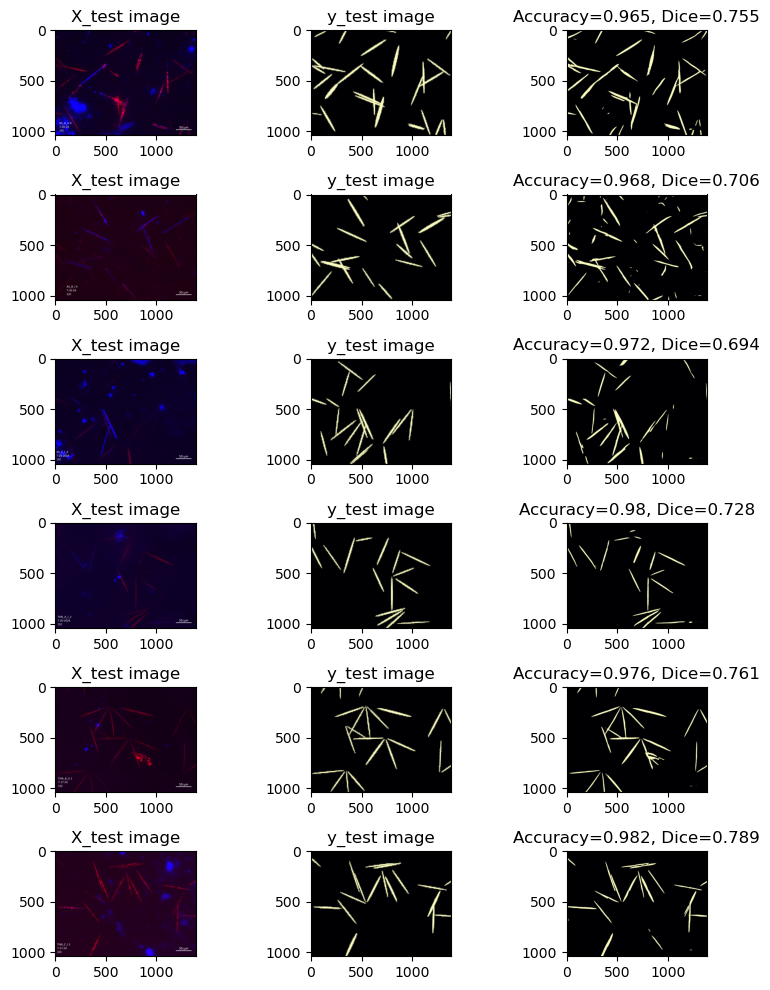

In [41]:
accuracies,dice_scores=[],[]
fig, ax = plt.subplots(6, 3, figsize=(8, 10))
for i in range(len(X)):
    accuracy=np.sum(y_cell[i]==((joined_predictions[i]>0.5)[:,:,0]))/(1388*1040)
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(y_cell[i], cmap='magma')
    ax[i,2].imshow(joined_predictions[i]>0.5, cmap='magma')
    ax[i,0].set_title("X_test image")
    ax[i,1].set_title("y_test image")
    ax[i,2].set_title("Accuracy="+str(round(accuracy,3))+", Dice="+str(DICE_COE(y_cell[i],(joined_predictions[i]>0.5)[:,:,0])))
    accuracies.append(accuracy)
    dice_scores.append(DICE_COE(y_cell[i],(joined_predictions[i]>0.5)[:,:,0]))
fig.tight_layout()

In [42]:
np.mean(accuracies)

0.9737807581467522

In [43]:
np.mean(dice_scores)

0.7388333333333333

In [44]:
#now figure out how to split predictions into individual cells
predictions=[(val>0.5)[:,:,0] for val in joined_predictions]

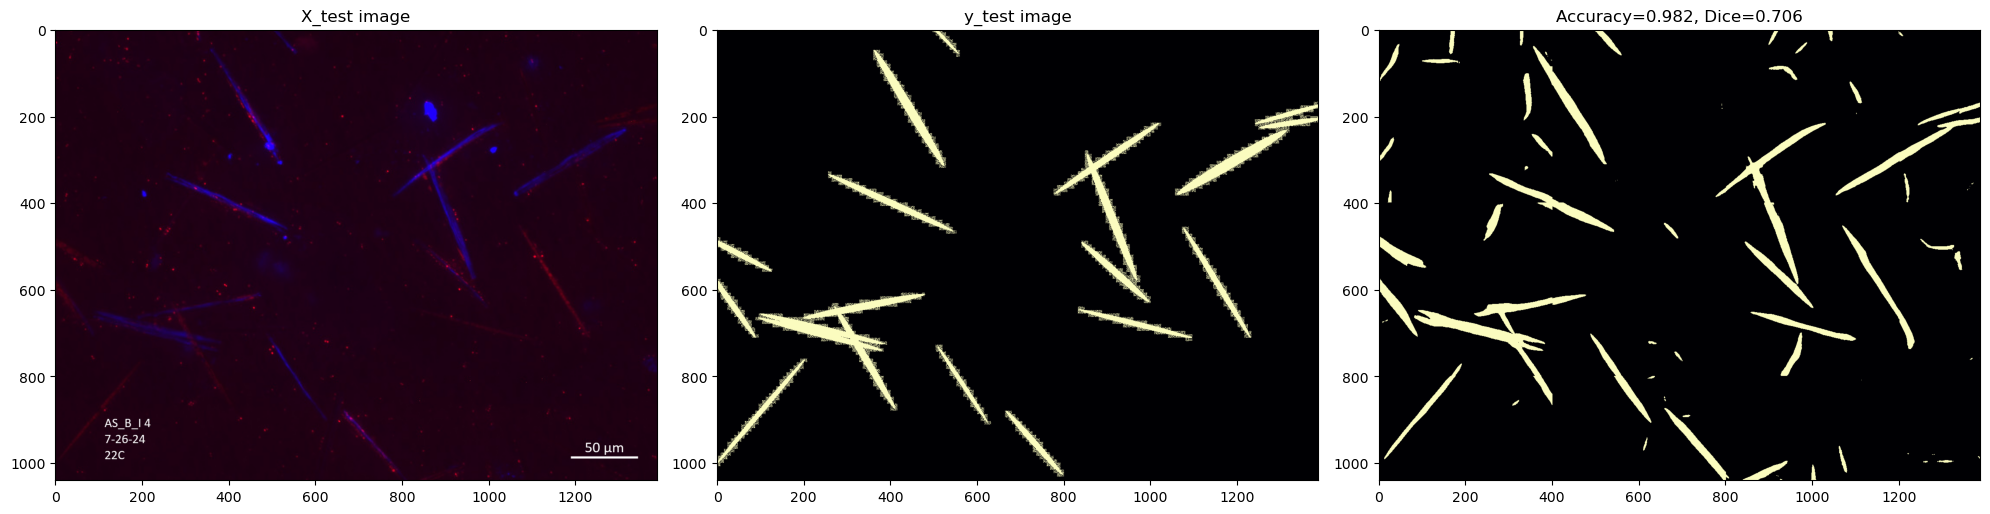

In [45]:
fig, ax = plt.subplots(1,3, figsize=(20, 7))
i=1
ax[0].imshow(X[i], cmap='magma')
ax[1].imshow(y_cell[i], cmap='magma')
ax[2].imshow(predictions[i], cmap='magma')
ax[0].set_title("X_test image")
ax[1].set_title("y_test image")
ax[2].set_title("Accuracy="+str(round(accuracy,3))+", Dice="+str(DICE_COE(y_cell[i],(joined_predictions[i]>0.5)[:,:,0])))
fig.tight_layout()

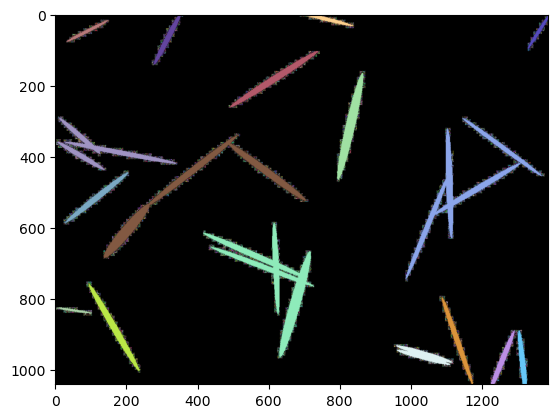

In [46]:
#get expected pixel range of cells from y_cell train data after splitting into non-overlapping blobs
def find_blobs(array):
    segmented_cells=np.zeros((1040,1388,3), dtype=np.uint8)
    
    coordinates_to_blobs=dict()
    current_blob=-1
    clean_array=np.copy(array)
    blob_sizes=[]
    for i in range(0,len(array)):
        for j in range(0,len(array[i])):    
            if array[i,j]==1 and f"{i},{j}" not in coordinates_to_blobs.keys():
                red,green,blue=np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)
                #start a new blob
                current_blob+=1
                coordinates_to_check=[f"{i},{j}"]
                x,y=i,j
                #print(f"Starting new blob {current_blob}.")
                while True:#expand outwards from current pixel position in all directions until no more filled coordinates are found
                    segmented_cells[x,y,0]=red
                    segmented_cells[x,y,1]=green
                    segmented_cells[x,y,2]=blue
                    coordinates_to_blobs[f"{x},{y}"]=current_blob
                    #check all four surrounding pixels
                    if x>0 and array[x-1,y]>0 and f"{x-1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x-1},{y}")
                    if x<len(array)-1 and array[x+1,y]>0 and f"{x+1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x+1},{y}")
                    if y>0 and array[x,y-1]>0 and f"{x},{y-1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y-1}")
                    if y<len(array[0])-1 and array[x,y+1]>0 and f"{x},{y+1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y+1}")
                    x=int(coordinates_to_check[-1].split(",")[0])
                    y=int(coordinates_to_check[-1].split(",")[1])
                    coordinates_to_check=coordinates_to_check[:-1]
                    if len(coordinates_to_check)==0:
                        #print(f"Blob {current_blob} has pixel size {sum([val==current_blob for val in list(coordinates_to_blobs.values())])}")
                        blob_sizes.append(sum([val==current_blob for val in list(coordinates_to_blobs.values())]))
                        break
    plt.imshow(segmented_cells)
    return coordinates_to_blobs,blob_sizes


coordinates_to_blobs,blob_sizes=find_blobs(y_cell[0])              

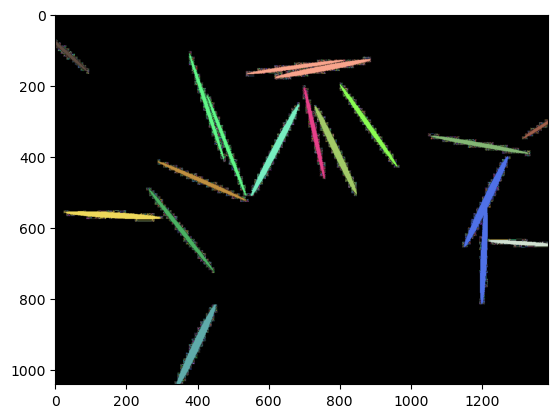

In [47]:
all_blob_sizes=[]
for img in y_cell:
    coordinates_to_blobs,blob_sizes=find_blobs(img)
    all_blob_sizes=all_blob_sizes+blob_sizes

(array([4.976e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.0000e+00, 1.8310e+02, 3.6520e+02, 5.4730e+02, 7.2940e+02,
        9.1150e+02, 1.0936e+03, 1.2757e+03, 1.4578e+03, 1.6399e+03,
        1.8220e+03, 2.0041e+03, 2.1862e+03, 2.3683e+03, 2.5504e+03,
        2.7325e+03, 2.9146e+03, 3.0967e+03, 3.2788e+03, 3.4609e+03,
        3.6430e+03, 3.8251e+03, 4.0072e+03, 4.1893e+03, 4.3714e+03,
        4.5535e+03, 4.7356e+03, 4.91

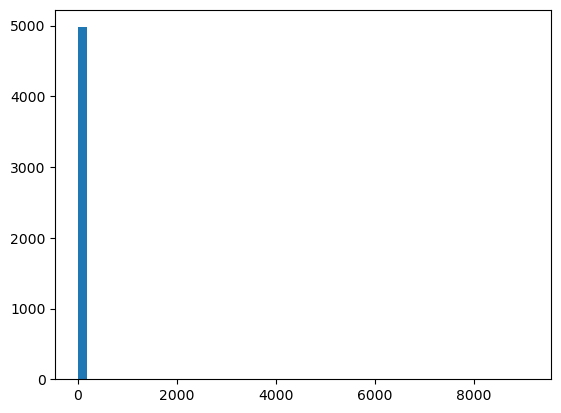

In [48]:
plt.hist(blob_sizes,bins=50)

In [49]:
min(blob_sizes)

1

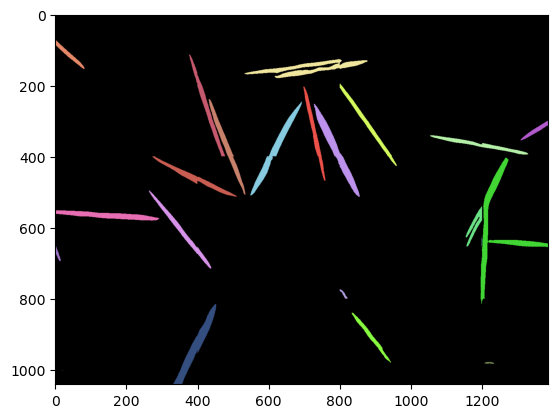

In [50]:
#for comparison, the y predictions
all_blob_sizes=[]
for img in predictions:
    coordinates_to_blobs,blob_sizes=find_blobs(img)
    all_blob_sizes=all_blob_sizes+blob_sizes

(array([3., 2., 0., 0., 0., 1., 1., 0., 0., 2., 0., 0., 0., 0., 0., 2., 1.,
        1., 1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2.00000e+00, 1.66720e+02, 3.31440e+02, 4.96160e+02, 6.60880e+02,
        8.25600e+02, 9.90320e+02, 1.15504e+03, 1.31976e+03, 1.48448e+03,
        1.64920e+03, 1.81392e+03, 1.97864e+03, 2.14336e+03, 2.30808e+03,
        2.47280e+03, 2.63752e+03, 2.80224e+03, 2.96696e+03, 3.13168e+03,
        3.29640e+03, 3.46112e+03, 3.62584e+03, 3.79056e+03, 3.95528e+03,
        4.12000e+03, 4.28472e+03, 4.44944e+03, 4.61416e+03, 4.77888e+03,
        4.94360e+03, 5.10832e+03, 5.27304e+03, 5.43776e+03, 5.60248e+03,
        5.76720e+03, 5.93192e+03, 6.09664e+03, 6.26136e+03, 6.42608e+03,
        6.59080e+03, 6.75552e+03, 6.92024e+03, 7.08496e+03, 7.24968e+03,
        7.41440e+03, 7.57912e+03, 7.74384e+03, 7.90856e+03, 8.07328e+03,
        8.23800e+03]),
 <BarContainer object

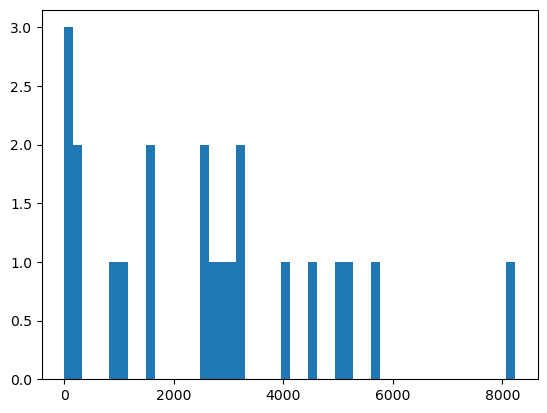

In [51]:
plt.hist(blob_sizes,bins=50)

In [52]:
min(blob_sizes)

2

In [53]:
#remove blobs below size 500 or so

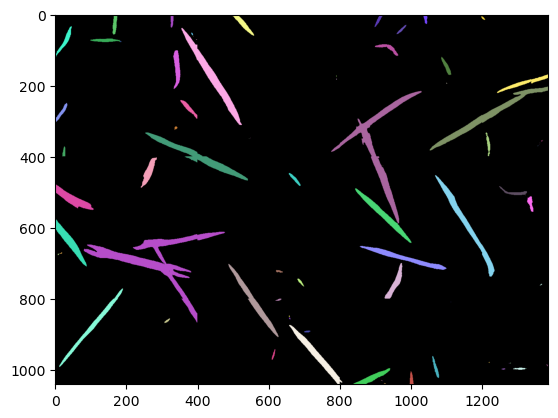

In [54]:
clean_predictions=[]

def remove_tiny_blobs(array,min_size=700):
    segmented_cells=np.zeros((1040,1388,3), dtype=np.uint8)
    clean_predictions=np.zeros((1040,1388), dtype=np.uint8)
    coordinates_to_blobs=dict()
    current_blob=-1
    clean_array=np.copy(array)
    blob_sizes=[]
    for i in range(0,len(array)):
        for j in range(0,len(array[i])):    
            if array[i,j]==1 and f"{i},{j}" not in coordinates_to_blobs.keys():
                red,green,blue=np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)
                #start a new blob
                current_blob+=1
                coordinates_to_check=[f"{i},{j}"]
                x,y=i,j
                while True:#expand outwards from current pixel position in all directions until no more filled coordinates are found
                    segmented_cells[x,y,0]=red
                    segmented_cells[x,y,1]=green
                    segmented_cells[x,y,2]=blue
                    coordinates_to_blobs[f"{x},{y}"]=current_blob
                    #check all four surrounding pixels
                    if x>0 and array[x-1,y]>0 and f"{x-1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x-1},{y}")
                    if x<len(array)-1 and array[x+1,y]>0 and f"{x+1},{y}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x+1},{y}")
                    if y>0 and array[x,y-1]>0 and f"{x},{y-1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y-1}")
                    if y<len(array[0])-1 and array[x,y+1]>0 and f"{x},{y+1}" not in coordinates_to_blobs.keys():
                        coordinates_to_check.append(f"{x},{y+1}")
                    x=int(coordinates_to_check[-1].split(",")[0])
                    y=int(coordinates_to_check[-1].split(",")[1])
                    coordinates_to_check=coordinates_to_check[:-1]
                    if len(coordinates_to_check)==0:
                        blob_sizes.append(sum([val==current_blob for val in list(coordinates_to_blobs.values())]))
                        break
    for coordinate_pair,current_blob in coordinates_to_blobs.items():
        if blob_sizes[current_blob]>=min_size:
            x=int(coordinate_pair.split(",")[0])
            y=int(coordinate_pair.split(",")[1])
            clean_predictions[x,y]=1
    plt.imshow(segmented_cells)
    return coordinates_to_blobs,blob_sizes,clean_predictions


coordinates_to_blobs,blob_sizes,clean_prediction=remove_tiny_blobs(predictions[1])    

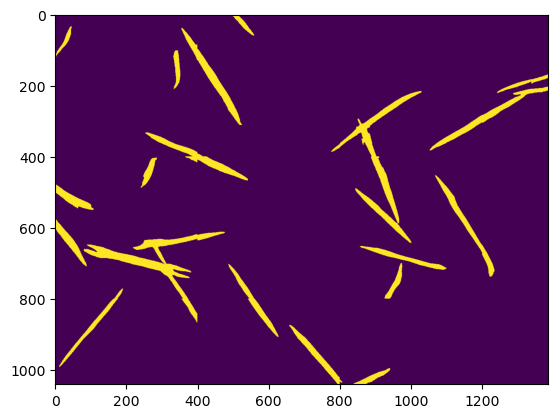

In [55]:
plt.imshow(clean_prediction)

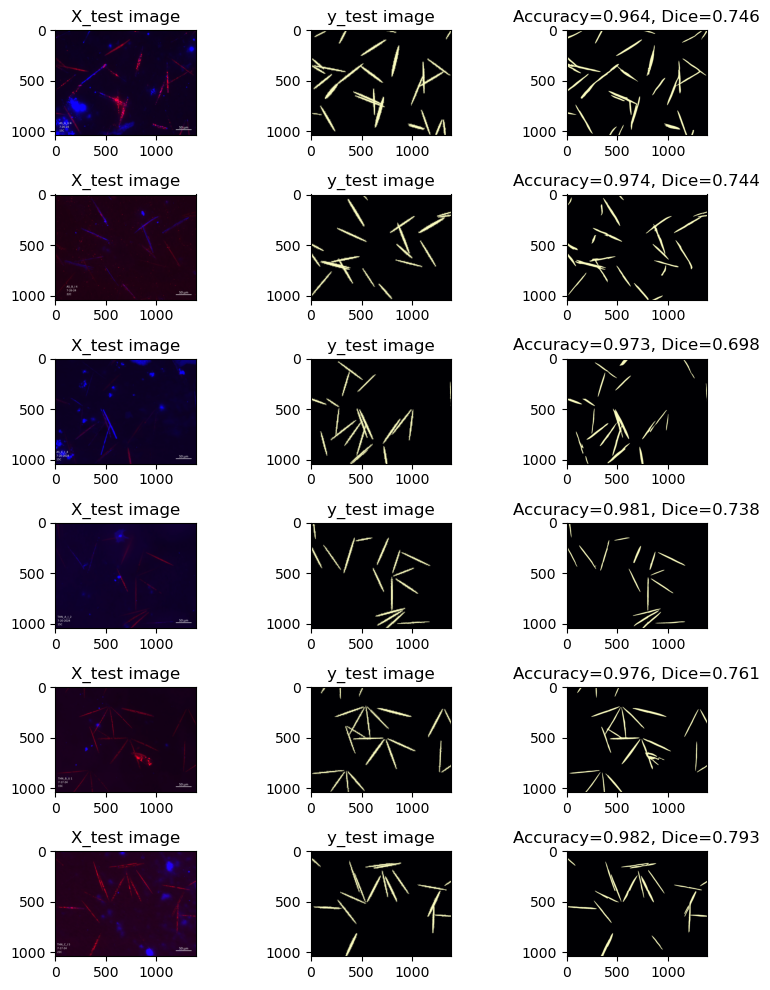

In [56]:
#see how accuracy and dice score changes when removing tiny blobs
accuracies,dice_scores=[],[]
fig, ax = plt.subplots(6, 3, figsize=(8, 10))
for i in range(len(X)):
    
    coordinates_to_blobs,blob_sizes,clean_prediction=remove_tiny_blobs(predictions[i])   
    accuracy=np.sum(y_cell[i]==clean_prediction)/(1388*1040)
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(y_cell[i], cmap='magma')
    ax[i,2].imshow(clean_prediction, cmap='magma')
    ax[i,0].set_title("X_test image")
    ax[i,1].set_title("y_test image")
    ax[i,2].set_title("Accuracy="+str(round(accuracy,3))+", Dice="+str(DICE_COE(y_cell[i],clean_prediction)))
    accuracies.append(accuracy)
    dice_scores.append(DICE_COE(y_cell[i],clean_prediction))
fig.tight_layout()

In [57]:
np.mean(accuracies)

0.9749160616640803

In [58]:
np.mean(dice_scores)

0.7466666666666666

Actually it looks like most images it found a fainter cell that was not annotated.  Tbh it's already doing a better job than I am.

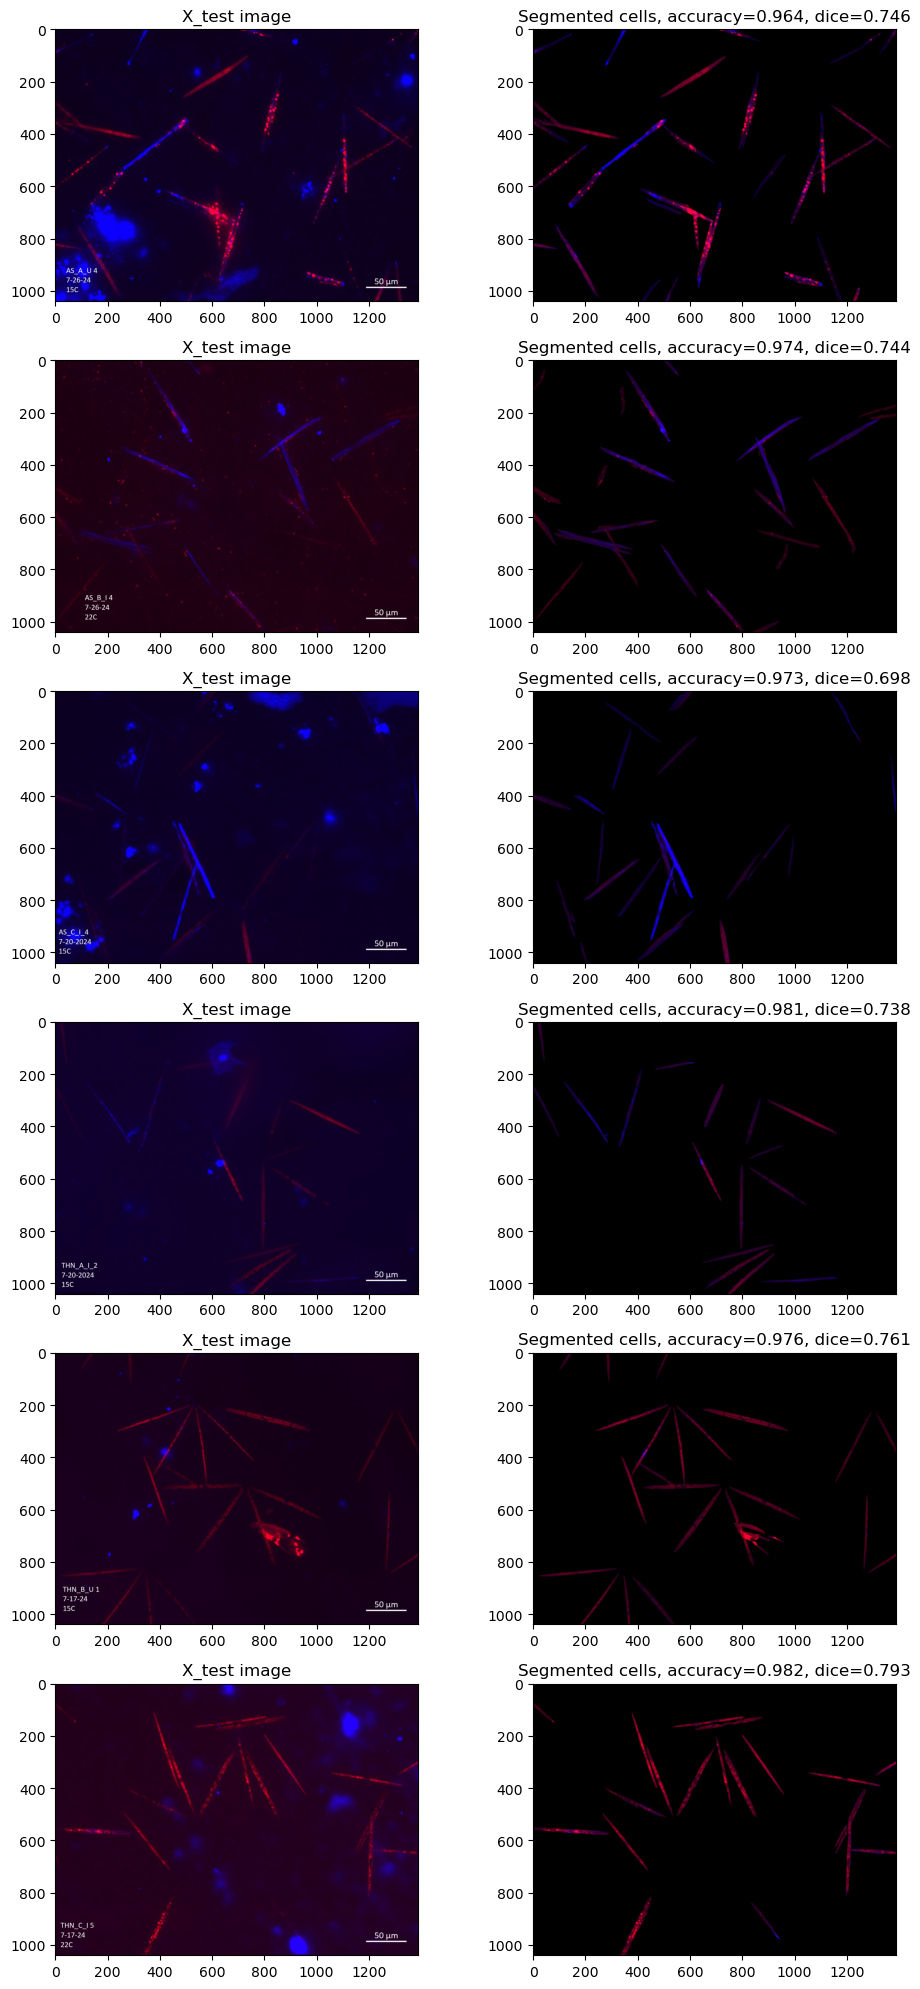

In [59]:
#Just for fun show we can output the clean images with background removed

accuracies,dice_scores=[],[]
fig, ax = plt.subplots(6, 2, figsize=(10, 20))
for i in range(len(X)):
    
    coordinates_to_blobs,blob_sizes,clean_prediction=remove_tiny_blobs(predictions[i]) 
    clean_image=np.copy(X[i])
    for x in range(len(X[i])):
        for y in range(len(X[i][0])):
            if clean_prediction[x,y]==0:
                clean_image[x,y,0]=0
                clean_image[x,y,1]=0
                clean_image[x,y,2]=0
    ax[i,0].imshow(X[i], cmap='magma')
    ax[i,1].imshow(clean_image, cmap='magma')
    ax[i,0].set_title("X_test image")
    accuracy=np.sum(y_cell[i]==clean_prediction)/(1388*1040)
    dice_score=DICE_COE(y_cell[i],clean_prediction)
    ax[i,1].set_title(f"Segmented cells, accuracy={round(accuracy,3)}, dice={dice_score}")
fig.tight_layout()

In [60]:
fig.savefig("ML_output/test_set_segmentation.png")